In [8]:
import numpy as np
from scipy.optimize import minimize
from matplotlib.lines import Line2D
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode
from scipy import special
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# ref: Efficient algorithm to compute the second Chern number in four dimensional systems
def Ham(mz,t0,tz,tso,tsoz,Uon,kx,ky,kz):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmax)
    gamma2 = np.kron(sigmay,sigmay)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 = mz - 2*t0*(np.cos(kx)+np.cos(ky))-2*tz*np.cos(kz)
    h1 = -2*tso*np.sin(kx)
    h2 = 2*tso*np.sin(ky)
    h3 = -2*tsoz*np.sin(kz)
    h4 = Uon
    H = h0*gamma0 + h1*gamma1 + h2*gamma2 + h3*gamma3 + h4*gamma4
    return H
    
def ProjectionTB(mz,t0,tz,tso,tsoz,Uon,kx,ky,kz):
    H = Ham(mz,t0,tz,tso,tsoz,Uon,kx,ky,kz)
    _,eigvec = np.linalg.eigh(H)
    eigvec1 = eigvec[:,0].reshape(4,1)
    eigvec2 = eigvec[:,1].reshape(4,1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def WillsonloopZTB(mz0,mz,t0,tz,tso,tsoz,Uon,kx,ky,kz,N):
    t = np.arange(0,2*N+2,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    Uoni = Uon*np.sin(0)
    mzi = mz0 - mz*np.cos(0)
    H = Ham(mzi,t0,tz,tso,tsoz,Uoni,kx,ky,kz)
    sigmaz = np.zeros((2,2),dtype=complex)
    _,eigvec = np.linalg.eigh(H)
    Pro = np.eye(4)
    for i in range(len(t)):
        Uont = Uon*np.sin(t[i])
        mzt = mz0 - mz*np.cos(t[i])
        Pro = ProjectionTB(mzt,t0,tz,tso,tsoz,Uont,kx,ky,kz)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@Pro@(eigvec[:,j].reshape(4,1)))[0][0]
            #sigmaz[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@Spin0@(eigvec[:,j].reshape(4,1)))[0][0]
    return U #,sigmaz


In [3]:
def getRaman1(o1, s1, m1, n1, l1):  # 找 M1 sin(kx) cos(ky) cos(kz) taux sigmax 对应的耦合
    if o1 == 'g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, -1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, 1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, -1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, 1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key, coefffinal

    
def getRaman2(o1,s1,m1,n1,l1): #找 -M1 cos(kx) sin(ky) cos(kz) taux sigmay 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, 1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, 1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key,coefffinal

def getRaman3(o1,s1,m1,n1,l1): #找 M2,0 cos(kx) cos(ky) sin(kz) taux sigmaz 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1 
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getRaman4(o1,s1,m1,n1,l1): #找 M2,1 cos(kx) cos(ky) cos(kz) taux sigma0 对应的耦合
    if o1=='g':
        o2='e' #o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0,  1 / 8),     
            (0, 0, -1,  1 / 8),
            (0, -1, 0,  1 / 8),
            (0, -1, -1,  1 / 8),
            (-1, 0, 0,  1 / 8),     
            (-1, 0, -1, 1 / 8),
            (-1, -1, 0,  1/ 8),
            (-1, -1, -1, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2='g'#o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1,  1 / 8),     
            (1, 1, 0,  1 / 8),
            (1, 0, 1,  1 / 8),
            (1, 0, 0,  1 / 8),
            (0, 1, 1,  1 / 8),     
            (0, 1, 0, 1 / 8),
            (0, 0, 1,  1/ 8),
            (0, 0, 0, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getBasis(numm,numn,numl):
    #q = np.array([qx,qy,qz])  
    truncm = list(range(-numm, numm + 1))
    truncn = list(range(-numn, numn + 1))
    truncl = list(range(-numl, numl + 1))
    basis = []
    index_map = {}
    idx = 0
    for o in ['g', 'e']:
        for s in ['up', 'down']:
            for mx in truncm:
                for ny in truncn:
                    for lz in truncl:
                        basis.append((o, s, mx, ny, lz))
                        index_map[(o, s, mx, ny, lz)] = idx
                        idx += 1
    return basis,index_map

def getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (1/2*px1**2 + 1/2*py1**2 + pz1**2) - 0.5*(V0+V0+Vz) #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic

        # Zeeman 项
        if o1 == 'g':
            H[i, i] += delta 
        elif o1 == 'e':
            H[i, i] -= delta 
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        
        for dx in [-1, 1]:
            key = (o1, s1, m1 + dx, n1, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dy in [-1, 1]:
            key = (o1, s1, m1, n1 + dy, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dz in [-1, 1]:
            key = (o1, s1, m1, n1, l1 + dz)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -Vz / 4

        key1,coeff1 = getRaman1(o1,s1,m1,n1,l1)
        key2,coeff2 = getRaman2(o1,s1,m1,n1,l1)
        key3,coeff3 = getRaman3(o1,s1,m1,n1,l1)
        key4,coeff4 = getRaman4(o1,s1,m1,n1,l1)

        for keyi1,keyv1 in enumerate(key1):
            j = index_map.get(keyv1)
            if j is not None:
                H[i, j] += M1*coeff1[keyi1]  # 可根据 σ 的结构继续细化

        for keyi2,keyv2 in enumerate(key2):
            j = index_map.get(keyv2)
            if j is not None:
                H[i, j] += M1*coeff2[keyi2]

        for keyi3,keyv3 in enumerate(key3):
            j = index_map.get(keyv3)
            if j is not None:
                H[i, j] += M20*coeff3[keyi3]

        for keyi4,keyv4 in enumerate(key4):
            j = index_map.get(keyv4)
            if j is not None:
                H[i, j] += M21*coeff4[keyi4]
    return H

def Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    eigvals,eigvecs = np.linalg.eigh(H)
    eigvec1 = eigvecs[:,0].reshape(len(H),1)
    eigvec2 = eigvecs[:,1].reshape(len(H),1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def WillsonloopZ(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N):
    t = np.arange(0,2*N+2,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    deltaini = delta0-delta*np.cos(t[0])
    M21i = M21*np.sin(t[0])
    Hin = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21i,deltaini)
    #H1 =  csr_matrix(H)
    eigvals, eigvecs = np.linalg.eigh(Hin)#eigsh(H1, k=10, which='SA',tol=1e-12)
    #indexE = np.argsort(eigvals)
    #sigmaz = np.zeros((2,2),dtype=complex)
    Pro = np.eye(len(Hin),dtype=complex)
    #SpinO = spinProjectionOperatorZ(numm,numn,numl)
    for i in range(len(t)):
        M21t = M21*np.sin(t[i])
        deltat = delta0-delta*np.cos(t[i])
        Pro = Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21t,deltat)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@Pro@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
            #sigmaz[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@SpinO@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
    return U #,sigmaz


In [4]:
# -----------------------------
# 1) 生成 3D BZ 高对称路径： (0,0,0)->(0,0,pi)->(pi,pi,pi)->(pi,pi,0)->(0,0,0)
# -----------------------------
def make_kpath(points, n_per_seg=80):
    """
    points: list of 3-vectors in radians
    n_per_seg: 每段的离散点数（越大越平滑）
    return:
      kpath: (N,3)
      s:     (N,) 路径累计弧长
      ticks: 高对称点所在的索引列表
    """
    k_list = []
    ticks = [0]
    for i in range(len(points) - 1):
        a = np.array(points[i], dtype=float)
        b = np.array(points[i+1], dtype=float)
        seg = np.linspace(a, b, n_per_seg, endpoint=False)  # 不包含终点，避免重复
        k_list.append(seg)
        ticks.append(ticks[-1] + seg.shape[0])
    k_list.append(np.array(points[-1], dtype=float)[None, :])  # 加入最后一个点
    kpath = np.vstack(k_list)

    # 累计弧长作为横坐标
    dk = np.diff(kpath, axis=0)
    ds = np.linalg.norm(dk, axis=1)
    s = np.concatenate([[0.0], np.cumsum(ds)])

    return kpath, s, ticks

V0, Vz = 2, 4
delta_amp = 0.065*2
M1, M20, M21 = 1, 1, 0.15
d0 = 0.13
numm, numn, numl = 2, 2, 3
Gamma = (0.0, 0.0, 0.0)
Z     = (0.0, 0.0, np.pi)
Z1 = (np.pi,0,np.pi)
Z2 = (np.pi,0,0)
R     = (np.pi, np.pi, np.pi)
M     = (np.pi, np.pi, 0.0)
points = [Gamma, Z, Z1, R, M, Gamma]

kpath, s, ticks = make_kpath(points, n_per_seg=20)
tick_labels = [r'$\Gamma$', r'$Z$', r'$R$', r'$M$', r'$\Gamma$']



In [5]:

ELattice = np.empty((kpath.shape[0], 2), dtype=float)
for i, (kx, ky, kz) in enumerate(kpath):

        # 如果 getHam 吃无量纲 q∈[-1,1]：用 /pi；若 getHam 吃弧度 k：去掉 /np.pi
        qx_n, qy_n, qz_n = kx/np.pi, ky/np.pi, kz/np.pi

        U = WillsonloopZ(qx_n,qy_n,qz_n,numm,numn,numl,V0,Vz,M1,M20,M21,d0,delta_amp,N=100)
        En, _ = np.linalg.eig(U)
        quasiEn = 1j*np.log(En)

        ELattice[i] = np.sort(quasiEn.real)
        

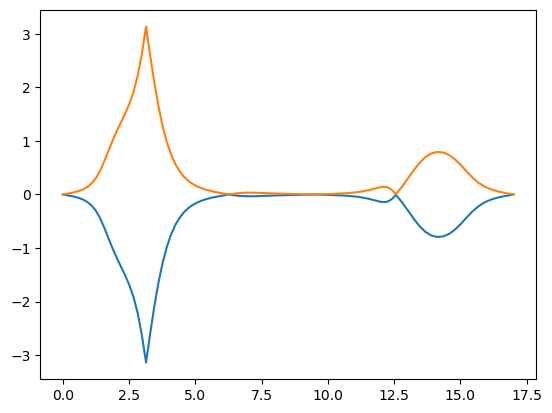

In [6]:
plt.plot(s,ELattice[:,0])
plt.plot(s,ELattice[:,1])


In [23]:

# ---------- 目标：给定 (t0,tso,ton) 计算 ETB ----------
def compute_ETB(t0, t0z, tso, tsoz, ton, N=100):
    ETB = np.empty((kpath.shape[0], 2), dtype=float)
    for i, (kx, ky, kz) in enumerate(kpath):
        U = WillsonloopZTB(d0, delta_amp, t0, t0z, tso, tsoz, ton, kx, ky, kz, N=N)
        ev = np.linalg.eigvals(U)          # 只算特征值更快
        phases = np.sort(1j*np.log(ev))     # 直接取相位 (-pi, pi]
        ETB[i] = phases
    return ETB

# ---------- 损失函数：MSE( wrap(ETB - ELattice) ) ----------
def loss(x, N_fit=80):
    t0,t0z, tso,tsoz, ton = x
    ETB = compute_ETB(t0,t0z, tso,tsoz, ton, N=N_fit)
    diff = (ETB - ELattice)      # 关键：相位差按 2pi 环绕
    return (np.mean(np.abs(diff)/(np.abs(ELattice)+1e3)))

# ---------- 用 minimize 优化 ----------
#x0 = np.array([0.089, 0.089/2, 0.04, 0.04, 0.55*0.16], dtype=float)
#x0 = np.array([0.0760937 , 0.04630901, 0.0527241 , 0.04   ,    0.09531837])
x0 = np.array([0.065 , 0.097, 0.05, 0.05 , 0.1])
# 可选：给参数加边界（强烈建议，防止跑飞）
bounds = [(0, 1),(0,1), (0, 1),(0, 1),(0.0, 1)]  # 按你的物理范围改

res = minimize(
    fun=lambda x: loss(x, N_fit=100),
    x0=x0,
    method="L-BFGS-B",
    bounds=bounds,
    jac="2-point",  # 数值差分梯度
    options={"maxiter": 500, "ftol": 1e-12, "disp": True},
)

print("best x =", res.x)
print("fit loss =", res.fun)

# ---------- 最终用更高精度复核 ----------
ETB_best = compute_ETB(*res.x, N=100)
final_loss = np.mean((ETB_best - ELattice)**2)
print("final_loss(N=100) =", final_loss)


/tmp/ipykernel_543555/2983686610.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  ETB[i] = phases


best x = [0.0650014  0.09700135 0.05       0.05000142 0.10000135]
fit loss = 1.4480431076161983e-05
final_loss(N=100) = 0.0005679206154985751


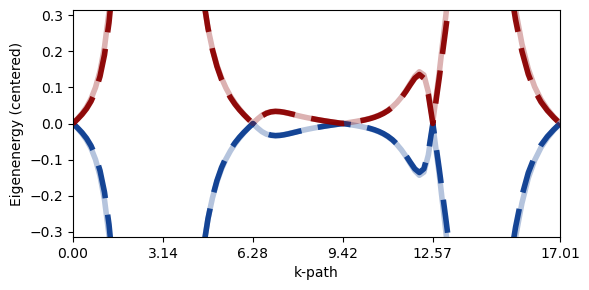

In [24]:

lower_color = "#0B3D91"  # deep blue
upper_color = "#8B0000"  # deep red

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for b in range(2):
    c = lower_color if b < 1 else upper_color

    # Full model: 实线
    ax.plot(
        s, ELattice[:, b],
        color=c, linestyle="-", linewidth=4, alpha=0.3
    )

    # TB: 虚线（同色，线型区分）
    ax.plot(
        s, ETB_best[:, b],
        color=c, linestyle="--", linewidth=4, alpha=0.95,
        dashes=(6, 3)  
    )


ax.set_xticks([s[t] for t in ticks])

ax.set_xlabel("k-path")
ax.set_ylabel("Eigenenergy (centered)")

plt.ylim(-np.pi/10,np.pi/10)
#plt.yticks([-np.pi,0,np.pi])
plt.xlim(s[0],s[-1])
fig.tight_layout()
#plt.savefig('TB_And_Lattice.svg')
plt.show()


In [25]:
kx = kpath[:, 0]
ky = kpath[:, 1]
kz = kpath[:, 2]

data = np.column_stack([
    kx, ky, kz,
    ELattice[:, 0], ELattice[:, 1],
    ETB_best[:, 0], ETB_best[:, 1],
])

np.savetxt(
    "Fig5.txt",
    data,
    delimiter="\t",
    fmt="%.10e",
    header="kx\tky\tkz\tELattice_down\tELattice_up\tETB_down\tETB_up",
    comments=""
)
